In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
class WageAnalyzer:
    def __init__(self, target_file='WAGE1.DTA'):
        self.target_file = target_file
        self.df = None
        
    def prepare_data(self, target_file=None):
        """
        Load and prepare data for wage analysis. The target file can be specified
        when calling the function, otherwise it uses the default file set during initialization.
        
        Parameters:
        -----------
        target_file : str, optional
            Name of the Stata data file to analyze. If not provided, uses the default file
            specified when creating the WageAnalyzer.
        
        Returns:
        --------
        pandas.DataFrame
            The prepared dataset with created variables like log_wage and exper2
        """
        # If a target file is provided, use it instead of the default
        if target_file is not None:
            self.target_file = target_file
            
        # Find and load the data file
        for root, dirs, files in os.walk('.'):
            if self.target_file in files:
                file_path = os.path.join(root, self.target_file)
                print(f"Found '{self.target_file}' at: {file_path}")
                self.df = pd.read_stata(file_path)
                break
        
        if self.df is None:
            print(f"The file '{self.target_file}' was not found.")
            return
            
        # Create log wage and experience squared
        self.df['log_wage'] = np.log(self.df['wage'])
        self.df['exper2'] = self.df['exper'].astype('int64') ** 2
                
        # Display summary statistics
        print("\nSummary Statistics:")
        print("=" * 80)
        print(self.df.info())
        print("=" * 80)
        print(self.df[['wage', 'log_wage', 'educ', 'exper', 'exper2']].describe())
        
        # Display correlation matrix
        print("\nCorrelation Matrix:")
        print("=" * 80)
        print(self.df[['wage', 'log_wage', 'educ', 'exper']].corr())
        
        return self.df
    
    def run_analysis(self, model_number=None):
        """
        Run wage analysis models individually or show available models.
        
        Parameters:
        -----------
        model_number : int or None
            If None, prints available models and their descriptions
            If 1, runs Model 1 (wage equation with nonwhite)
            If 2, runs Model 2 (gender wage gap)
            If 3, runs Model 3 (full model with regional effects)
            If 4, runs Model 4 (base human capital model)
        
        Returns:
        --------
        regression_results: statsmodels results object or None
        """
        if self.df is None:
            print("Please run prepare_data() first before running any models.")
            return None
        
        if model_number is None:
            print("Available Models:")
            print("-" * 80)
            print("Model 1: Wage equation with nonwhite")
            print("       - log(wage) = β₁ + β₂educ + β₃exper + β₄exper² + β₅nonwhite + ε")
            print("\nModel 2: Gender wage gap analysis")
            print("       - log(wage) = β₁ + β₂educ + β₃exper + β₄exper² + β₅female + ε")
            print("\nModel 3: Full model with regional effects")
            print("       - log(wage) = β₁ + β₂educ + β₃exper + β₄exper² + β₅female + ")
            print("                     β₆married + β₇northcen + β₈south + β₉west + ε")
            print("\nModel 4: Base human capital model")
            print("       - log(wage) = β₁ + β₂educ + β₃exper + β₄exper² + ε")
            return None
        
        # Run the specified model
        if model_number == 1:
            return self.run_model1()
        elif model_number == 2:
            return self.run_model2()
        elif model_number == 3:
            return self.run_model3()
        elif model_number == 4:
            return self.run_model4()
        else:
            print(f"Error: Model {model_number} not found. Please choose 1, 2, 3, or 4.")
            return None
    
    def run_model1(self):
        """
        Run the basic wage equation:
        log(wage) = β₁ + β₂educ + β₃exper + β₄exper² + ε
        """
        if self.df is None:
            print("Please run prepare_data() first.")
            return
            
        print("\nModel 1: Basic Wage Equation")
        print("=" * 80)
        
        # Prepare variables
        X = self.df[['educ', 'exper', 'exper2', 'nonwhite']]
        X = sm.add_constant(X)
        y = self.df['log_wage']
        
        # Run regression
        model = sm.OLS(y, X)
        results = model.fit()
        
        # Print results
        print(results.summary())

        # Add specific interpretation for nonwhite coefficient
        nonwhite_coef = results.params['nonwhite']
        nonwhite_std = results.bse['nonwhite']
        nonwhite_p = results.pvalues['nonwhite']
        
        print("\nNonwhite Wage Differential Interpretation:")
        print("-" * 80)
        print(f"Coefficient on nonwhite: {nonwhite_coef:.2f}")
        print(f"Standard error: {nonwhite_std:.2f}")
        print(f"p-value: {nonwhite_p:.2f}")
        
        # Calculate percentage effect
        pct_effect = (np.exp(nonwhite_coef) - 1) * 100
        
        print(f"\nInterpretation: Being nonwhite is associated with a {pct_effect:.1f}% ")
        print("difference in wages, holding education and experience constant.")
        if nonwhite_p < 0.05:
            print("This effect is statistically significant at the 5% level.")
        else:
            print("This effect is not statistically significant at the 5% level.")
        
        # Diagnostic plots
        self._plot_diagnostics(results, "Model 1")
        
        # Heteroskedasticity test
        self._check_heteroskedasticity(results)
        
        return results
    
    def run_model2(self):
        """
        Run the gender wage gap model:
        log(wage) = β₁ + β₂educ + β₃exper + β₄exper² + β₅female + ε
        """
        if self.df is None:
            print("Please run prepare_data() first.")
            return
            
        print("\nModel 2: Gender Wage Gap Analysis")
        print("=" * 80)
        
        # Prepare variables
        X = self.df[['educ', 'exper', 'exper2', 'female']]
        X = sm.add_constant(X)
        y = self.df['log_wage']
        
        # Run regression
        model = sm.OLS(y, X)
        results = model.fit()
        
        # Print results
        print(results.summary())

        # Add specific interpretation for nonwhite coefficient
        female_coef = results.params['female']
        female_std = results.bse['female']
        female_p = results.pvalues['female']
        
        print("\nFemale Wage Differential Interpretation:")
        print("-" * 80)
        print(f"Coefficient on female: {female_coef:.2f}")
        print(f"Standard error: {female_std:.2f}")
        print(f"p-value: {female_p:.2f}")
        
        # Calculate percentage effect
        pct_effect = (np.exp(female_coef) - 1) * 100
        
        print(f"\nInterpretation: Being female is associated with a {pct_effect:.1f}% ")
        print("difference in wages, holding education and experience constant.")
        if female_p < 0.05:
            print("This effect is statistically significant at the 5% level.")
        else:
            print("This effect is not statistically significant at the 5% level.")
        
        # Diagnostic plots
        self._plot_diagnostics(results, "Model 2")
        
        # Heteroskedasticity test
        self._check_heteroskedasticity(results)
        
        return results
    
    def run_model3(self):
        """
        Run the full model with regional effects:
        log(wage) = β₁ + β₂educ + β₃exper + β₄exper² + β₅female + β₆married + 
                    β₇northcen + β₈south + β₉west + ε
        """
        if self.df is None:
            print("Please run prepare_data() first.")
            return
            
        print("\nModel 3: Full Model with Regional Effects")
        print("=" * 80)
        
        # Prepare variables
        X = self.df[['educ', 'exper', 'exper2', 'female', 'married', 
                     'northcen', 'south', 'west']]
        X = sm.add_constant(X)
        y = self.df['log_wage']
        
        # Run regression
        model = sm.OLS(y, X)
        results = model.fit()
        
        # Print results
        print(results.summary())

        # Specific interpretation for regional effects
        print("\nRegional Wage Differentials (relative to Northeast):")
        print("-" * 80)
        
        # Calculate and display effect for South
        south_coef = results.params['south']
        south_std = results.bse['south']
        south_p = results.pvalues['south']
        
        # Convert log points to percentage
        south_pct = (np.exp(south_coef) - 1) * 100
        
        print(f"\nSouth vs Northeast:")
        print(f"Coefficient: {south_coef:.4f}")
        print(f"Standard error: {south_std:.4f}")
        print(f"p-value: {south_p:.4f}")
        print(f"Percentage difference: {south_pct:.1f}%")
        
        if south_p < 0.05:
            print("This difference is statistically significant at the 5% level.")
        else:
            print("This difference is not statistically significant at the 5% level.")
        
        # Diagnostic plots
        self._plot_diagnostics(results, "Model 3")
        
        # Heteroskedasticity test
        self._check_heteroskedasticity(results)
        
        return results

    def run_model4(self):
        """
        Run and analyze the base human capital model using WAGE2.DTA, with special focus
        on examining multicollinearity and the relationship between experience variables.
        
        Model: log(wage) = β₁ + β₂educ + β₃exper + β₄exper² + ε
        """
        if self.df is None:
            print("Please run prepare_data() first.")
            return
                
        print("\nModel 4: Base Human Capital Model (Young Workers)")
        print("=" * 80)
    
        # First, let's analyze the experience variables
        print("\n1. Analysis of Experience Variables:")
        print("-" * 50)
        
        # Summary statistics
        exp_stats = self.df[['exper', 'exper2']].describe()
        print("\nSummary Statistics for Experience Variables:")
        print(exp_stats)
        
        # Correlation analysis
        print("\n2. Correlation Analysis:")
        print("-" * 50)
        corr_matrix = self.df[['exper', 'exper2']].corr()
        print("\nCorrelation between experience and its square:")
        print(corr_matrix)
    
        # Multicollinearity analysis
        print("\n2. Multicollinearity Analysis:")
        print("-" * 50)
        print("We'll use Variance Inflation Factors (VIF) to quantify multicollinearity.")
        print("VIF > 10 typically indicates problematic multicollinearity.")
        
        # Prepare variables for VIF calculation
        X = self.df[['educ', 'exper', 'exper2']]
        X_with_const = sm.add_constant(X)
        
        # Calculate and display VIF
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X_with_const.columns
        vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                           for i in range(X_with_const.shape[1])]
        print("\nVariance Inflation Factors:")
        print(vif_data)
        
        # Run the main regression
        y = self.df['log_wage']
        model = sm.OLS(y, X_with_const)
        results = model.fit()
        
        print("\n3. Regression Results:")
        print("-" * 50)
        print(results.summary())
        
        # Heteroskedasticity analysis
        print("\n4. Heteroskedasticity Analysis:")
        print("-" * 50)
        
        # Test for heteroskedasticity
        self._check_heteroskedasticity(results)
        
        # Diagnostic plots
        self._plot_diagnostics(results, "Model 4")

        # Residuals vs Experience plot
        plt.figure(figsize=(10, 6))
        plt.scatter(self.df['exper'], results.resid, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Experience')
        plt.ylabel('Residuals')
        plt.title('Residuals vs Experience')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return results
    
    def _plot_diagnostics(self, results, title):
        """
        Create diagnostic plots for the regression analysis, displaying them side by side
        for easier comparison and interpretation.
        
        Parameters:
        -----------
        results : statsmodels results object
            Contains the regression results including residuals and fitted values
        title : str
            Title of the model being analyzed
        """
        # Create a single figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Left subplot: Residuals vs Fitted plot
        ax1.scatter(results.fittedvalues, results.resid, alpha=0.5)
        ax1.axhline(y=0, color='r', linestyle='--')
        ax1.set_xlabel('Fitted values')
        ax1.set_ylabel('Residuals')
        ax1.set_title(f'Residuals vs Fitted Values - {title}')
        
        # Right subplot: Q-Q plot
        stats.probplot(results.resid, dist="norm", plot=ax2)
        ax2.set_title(f'Q-Q Plot - {title}')
        
        # Adjust the layout to prevent overlap
        plt.tight_layout()
        
        # Display the plots
        plt.show()
    
    def _check_heteroskedasticity(self, results):
        """Perform White's test for heteroskedasticity"""
        white_test = het_white(results.resid, results.model.exog)
        lm_stat, lm_pval, f_stat, f_pval = white_test
        
        print("\nHeteroskedasticity Test (White's test):")
        print("-" * 50)
        print(f"LM statistic: {lm_stat:.4f}")
        print(f"LM test p-value: {lm_pval:.4f}")
        print(f"F statistic: {f_stat:.4f}")
        print(f"F-test p-value: {f_pval:.4f}")
        
        if lm_pval < 0.05:
            print("\nEvidence of heteroskedasticity detected (p < 0.05)")
            print("Consider using robust standard errors")
        else:
            print("\nNo significant evidence of heteroskedasticity (p >= 0.05)")

<h2>Analysis</h2>

<h3>Data preparation</h3>

In [7]:
analyzer = WageAnalyzer('WAGE1.DTA')
analyzer.prepare_data()

Found 'WAGE1.DTA' at: ./WAGE1.DTA

Summary Statistics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   wage      526 non-null    float32
 1   educ      526 non-null    int8   
 2   exper     526 non-null    int8   
 3   tenure    526 non-null    int8   
 4   nonwhite  526 non-null    int8   
 5   female    526 non-null    int8   
 6   married   526 non-null    int8   
 7   numdep    526 non-null    int8   
 8   smsa      526 non-null    int8   
 9   northcen  526 non-null    int8   
 10  south     526 non-null    int8   
 11  west      526 non-null    int8   
 12  construc  526 non-null    int8   
 13  ndurman   526 non-null    int8   
 14  trcommpu  526 non-null    int8   
 15  trade     526 non-null    int8   
 16  services  526 non-null    int8   
 17  profserv  526 non-null    int8   
 18  profocc   526 non-null    int8   
 19  clerocc   526 no

,wage,educ,exper,tenure,nonwhite,female,married,numdep,smsa,northcen,...,trcommpu,trade,services,profserv,profocc,clerocc,servocc,tenursq,log_wage,exper2
0,3.10,11,2,0,0,1,0,2,1,0,...,0,0,0,0,0,0,0,0,1.131402,4
1,3.24,12,22,2,0,1,1,3,1,0,...,0,0,1,0,0,0,1,4,1.175573,484
2,3.00,11,2,0,0,0,0,2,0,0,...,0,1,0,0,0,0,0,0,1.098612,4
3,6.00,8,44,28,0,0,1,0,1,0,...,0,0,0,0,0,1,0,784,1.791759,1936
4,5.30,12,7,2,0,0,1,1,0,0,...,0,0,0,0,0,0,0,4,1.667707,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,15.00,16,14,2,0,1,1,2,0,0,...,0,0,0,1,1,0,0,4,2.708050,196
522,2.27,10,2,0,0,1,0,3,0,0,...,0,1,0,0,1,0,0,0,0.819780,4
523,4.67,15,13,18,0,0,1,3,0,0,...,0,0,0,0,1,0,0,324,1.541159,169
524,11.56,16,5,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,2.447551,25


In [9]:
analyzer.run_analysis()

Available Models:
--------------------------------------------------------------------------------
Model 1: Wage equation with nonwhite
       - log(wage) = β₁ + β₂educ + β₃exper + β₄exper² + β₅nonwhite + ε

Model 2: Gender wage gap analysis
       - log(wage) = β₁ + β₂educ + β₃exper + β₄exper² + β₅female + ε

Model 3: Full model with regional effects
       - log(wage) = β₁ + β₂educ + β₃exper + β₄exper² + β₅female + 
                     β₆married + β₇northcen + β₈south + β₉west + ε

Model 4: Base human capital model
       - log(wage) = β₁ + β₂educ + β₃exper + β₄exper² + ε


<h3>Model 1: Basic wage equation</h3>


Model 1: Basic Wage Equation
                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     55.90
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           3.14e-39
Time:                        13:08:28   Log-Likelihood:                -319.52
No. Observations:                 526   AIC:                             649.0
Df Residuals:                     521   BIC:                             670.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1305 

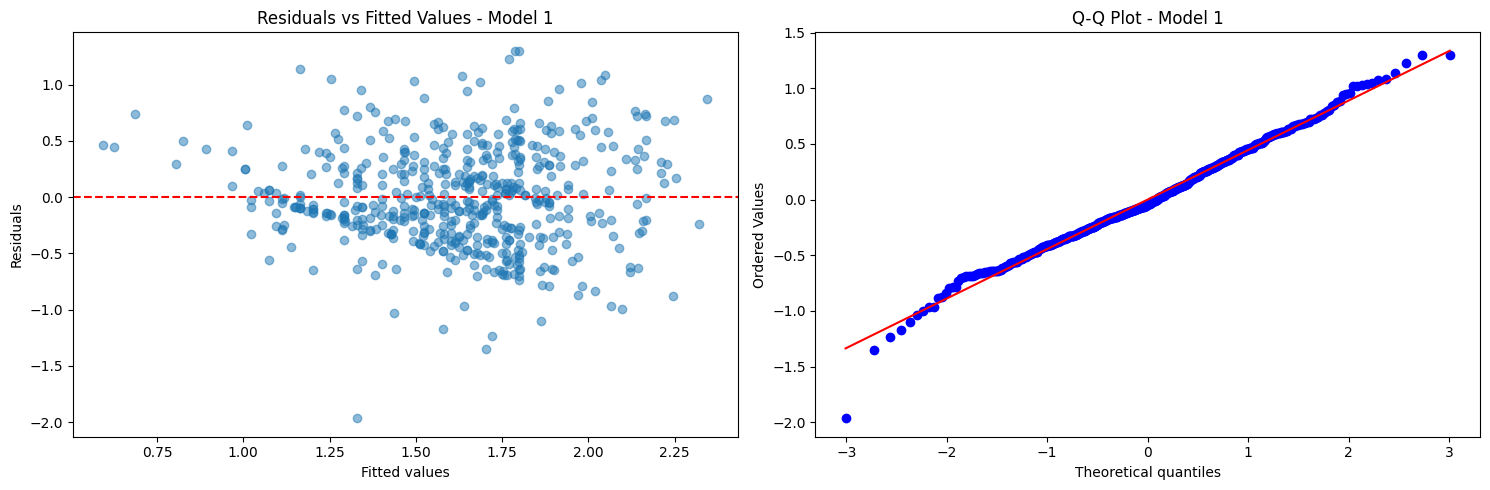


Heteroskedasticity Test (White's test):
--------------------------------------------------
LM statistic: 31.7988
LM test p-value: 0.0015
F statistic: 2.7507
F-test p-value: 0.0012

Evidence of heteroskedasticity detected (p < 0.05)
Consider using robust standard errors


In [12]:
results1 = analyzer.run_analysis(1)

<h4>Interpretation:</h4>
<p>Lorem ipsum</p>

<h3>Model 2: Gender Wage Gap Analysis</h3>


Model 2: Gender Wage Gap Analysis
                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     86.69
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           2.03e-56
Time:                        13:08:33   Log-Likelihood:                -279.27
No. Observations:                 526   AIC:                             568.5
Df Residuals:                     521   BIC:                             589.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.

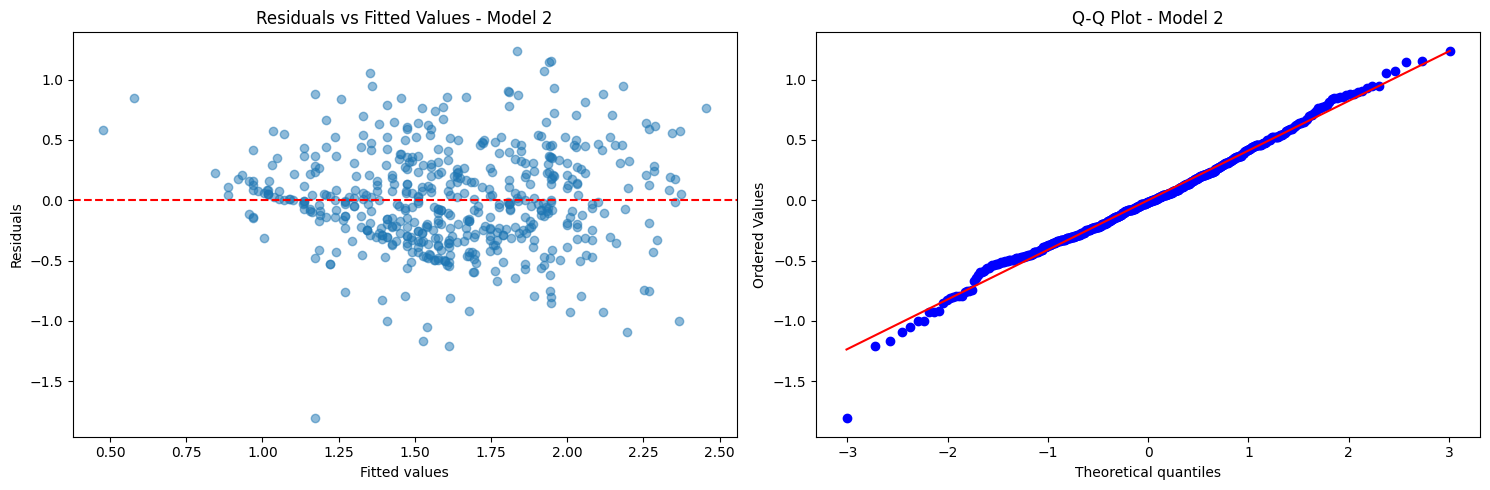


Heteroskedasticity Test (White's test):
--------------------------------------------------
LM statistic: 19.9303
LM test p-value: 0.0684
F statistic: 1.6836
F-test p-value: 0.0669

No significant evidence of heteroskedasticity (p >= 0.05)


In [16]:
results2 = analyzer.run_analysis(2)


Model 3: Full Model with Regional Effects
                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     45.95
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           1.09e-55
Time:                        13:08:35   Log-Likelihood:                -272.19
No. Observations:                 526   AIC:                             562.4
Df Residuals:                     517   BIC:                             600.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

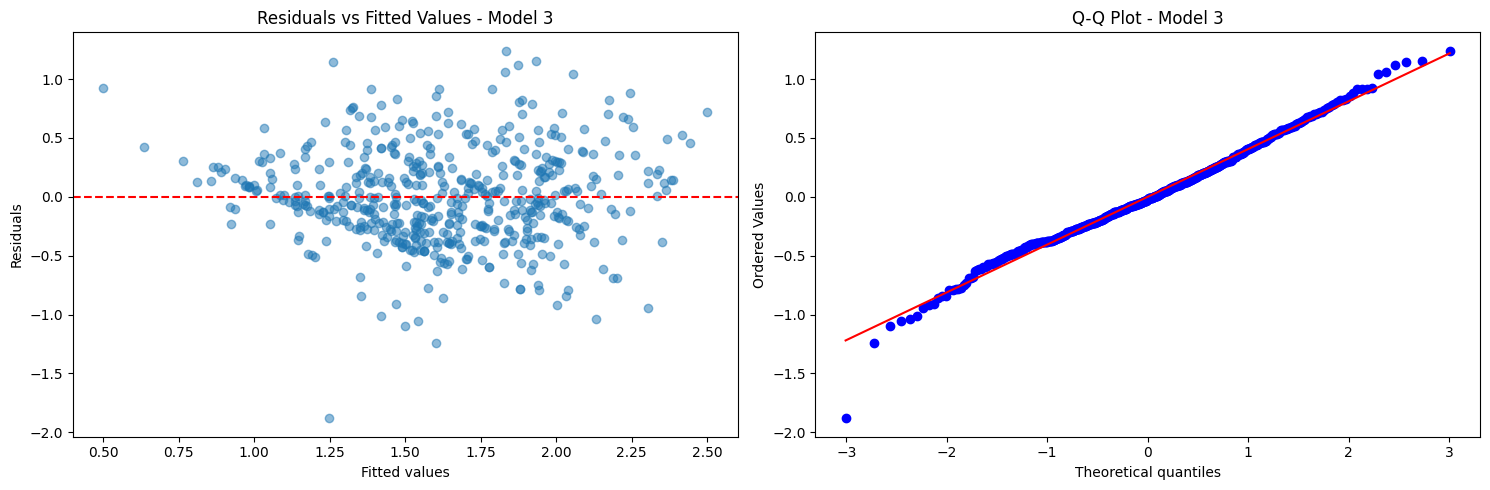


Heteroskedasticity Test (White's test):
--------------------------------------------------
LM statistic: 45.4880
LM test p-value: 0.1104
F statistic: 1.3253
F-test p-value: 0.1047

No significant evidence of heteroskedasticity (p >= 0.05)


In [18]:
results3 = analyzer.run_analysis(3)

In [20]:
print("\nNote about the Dummy Variable Trap:")
print("-" * 80)
print("This model avoids the dummy variable trap by using Northeast as the")
print("reference category. We don't include a Northeast dummy because:")
print("1. Including all regional dummies would create perfect multicollinearity")
print("2. Each regional coefficient represents the wage difference compared to Northeast")
print("3. We can recover the Northeast effect from the other coefficients")


Note about the Dummy Variable Trap:
--------------------------------------------------------------------------------
This model avoids the dummy variable trap by using Northeast as the
reference category. We don't include a Northeast dummy because:
1. Including all regional dummies would create perfect multicollinearity
2. Each regional coefficient represents the wage difference compared to Northeast
3. We can recover the Northeast effect from the other coefficients


In [23]:
analyzer = WageAnalyzer('WAGE2.DTA')
analyzer.prepare_data()

Found 'WAGE2.DTA' at: ./WAGE2.DTA

Summary Statistics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   wage      935 non-null    int16  
 1   hours     935 non-null    int8   
 2   IQ        935 non-null    int16  
 3   KWW       935 non-null    int8   
 4   educ      935 non-null    int8   
 5   exper     935 non-null    int8   
 6   tenure    935 non-null    int8   
 7   age       935 non-null    int8   
 8   married   935 non-null    int8   
 9   black     935 non-null    int8   
 10  south     935 non-null    int8   
 11  urban     935 non-null    int8   
 12  sibs      935 non-null    int8   
 13  brthord   852 non-null    float64
 14  meduc     857 non-null    float64
 15  feduc     741 non-null    float64
 16  lwage     935 non-null    float32
 17  log_wage  935 non-null    float32
 18  exper2    935 non-null    int64  
dtypes: float32(2), f

,wage,hours,IQ,KWW,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc,lwage,log_wage,exper2
0,769,40,93,35,12,11,2,31,1,0,0,1,1,2.0,8.0,8.0,6.645091,6.645091,121
1,808,50,119,41,18,11,16,37,1,0,0,1,1,NaN,14.0,14.0,6.694562,6.694562,121
2,825,40,108,46,14,11,9,33,1,0,0,1,1,2.0,14.0,14.0,6.715384,6.715384,121
3,650,40,96,32,12,13,7,32,1,0,0,1,4,3.0,12.0,12.0,6.476973,6.476973,169
4,562,40,74,27,11,14,5,34,1,0,0,1,10,6.0,6.0,11.0,6.331502,6.331502,196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,520,40,79,28,16,6,1,30,1,1,1,0,0,1.0,11.0,NaN,6.253829,6.253829,36
931,1202,40,102,32,13,10,3,31,1,0,1,1,7,7.0,8.0,6.0,7.091742,7.091742,100
932,538,45,77,22,12,12,10,28,1,1,1,0,9,NaN,7.0,NaN,6.287858,6.287858,144
933,873,44,109,25,12,12,12,28,1,0,1,0,1,1.0,NaN,11.0,6.771935,6.771935,144



Model 4: Base Human Capital Model (Young Workers)

1. Analysis of Experience Variables:
--------------------------------------------------

Summary Statistics for Experience Variables:
            exper      exper2
count  935.000000  935.000000
mean    11.563636  152.834225
std      4.374586  105.169453
min      1.000000    1.000000
25%      8.000000   64.000000
50%     11.000000  121.000000
75%     15.000000  225.000000
max     23.000000  529.000000

2. Correlation Analysis:
--------------------------------------------------

Correlation between experience and its square:
           exper    exper2
exper   1.000000  0.976119
exper2  0.976119  1.000000

2. Multicollinearity Analysis:
--------------------------------------------------
We'll use Variance Inflation Factors (VIF) to quantify multicollinearity.
VIF > 10 typically indicates problematic multicollinearity.

Variance Inflation Factors:
  Variable        VIF
0    const  94.201019
1     educ   1.278872
2    exper  21.190556
3   

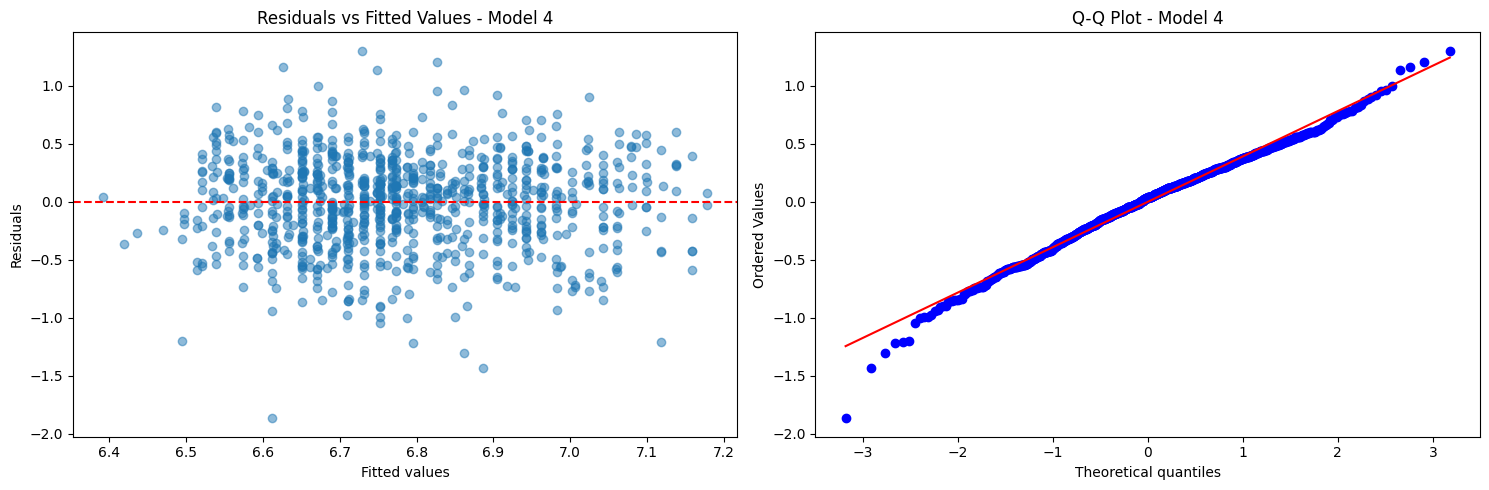

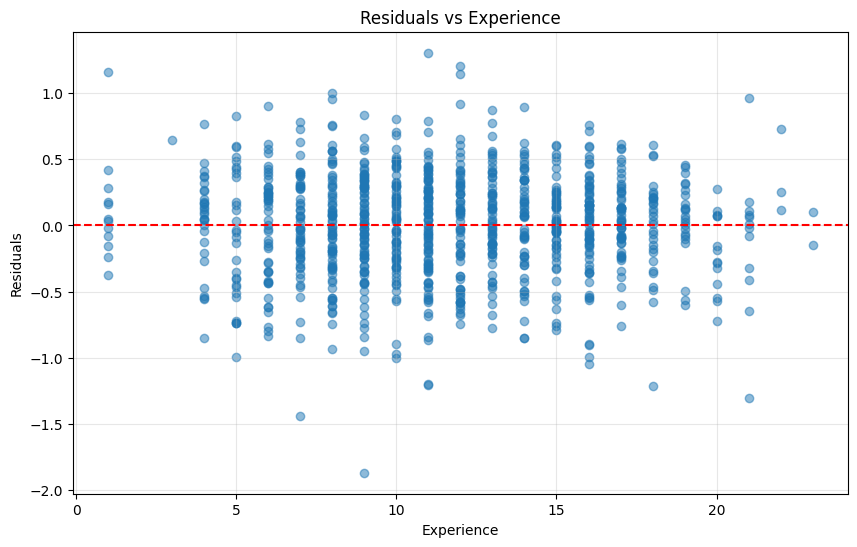

In [25]:
results4 = analyzer.run_analysis(4)

<h4>Interpretation:</h4>
<p>Lorem ipsum</p>

<h4>Interpretation:</h4>
<h5>Variations in the variables exper and exper2:</h5>
    <ul>
        <li>The experience variable (exper) has interesting characteristics. The mean experience is about 11.6 years and ranges from 1 year to 23 years. The standard deviation is about 4.4 years, which indicats moderate variability. The median is 11 years, very close to the mean, suggesting a fairly symmetric distribution.</li>
        <li>For the squared experience variable (exper2), we observe that has a much larger range, from -112 to 121, and standard deviation is also much larger (71.97), which is expected when squaring values. Naturally, the distribution appears more spread out as well, which is natural when squaring numbers.</li>
    </ul>
<h5>Correlation between exper and exper2:</h5>
    <ul>
        <li>Based on the output, the correlation coefficient between exper and exper2 is -0.297465, which might seem surprising at first. This negative correlation could be explained by the specific characteristics of this dataset, which focuses on young respondents.</li>
        <li>In a dataset of young workers, we might see this pattern because the range of experience is more limited, or there might be more observations at lower experience levels. The squared term creates a non-linear relationship that, when combined with the young sample, produces this negative correlation. </li>
    </ul>
